### Word2Vec

In [1]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import time

#### Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


#### Read the data into a string

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


#### Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
        
    for word, _ in count:
        dictionary[word] = len(dictionary) # dictionary indexing
        #print (dictionary)
    
    data = list()
    unk_count = 0
    
    # dictionary에 있으면 해당 index, 아니면(UNK) index =0
    # unk 의 전체 개수 세기
    for word in words:
        if word in dictionary:
            index = dictionary[word]
            # 위에서 len으로 정의한 dictionary의 단어 indexing
            # index가 낮을수록 빈번
            
        else:
            index = 0 # dictionary['UNK']
            unk_count = unk_count +1
        data.append(index) # 각 단어들의 index를 data 에 입력
        
    count[0][1] = unk_count # UNK의 개수
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    # reverse_dictionary: dictionary의 key와 value를 변경
    # index(key)가 낮을수록 빈번
    
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('Sample count', count[:10])
print('Sample dict', dictionary.items()[:10])
print('Sample Reverse Dictionary', reverse_dictionary.items()[:10])
#del words # Reduce memory

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
Sample count [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
Sample dict [('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554), ('sowell', 40562), ('sonja', 38175), ('showa', 32906), ('woods', 6263), ('hsv', 44222)]
Sample Reverse Dictionary [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


In [5]:
print(len(data))
print(len(count))
print(len(dictionary))

17005207
50000
50000


#### Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    """
    input
    
    batch_size:    batch size
    num_skips:     context window 내에서의 예측값 후보 개수
    skip_window:   context window 크기
    
    
    return
    
    batch:         mini-batch of data
    labels:        labels of mini-batch
    
    """
    global data_index
    assert batch_size % num_skips == 0 # batch_size는 num_skips의 배수
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape =(batch_size), dtype=np.int32)
    labels = np.ndarray(shape =(batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1 # [ skip window         target        skip window ]
    buffer = collections.deque(maxlen = span)
    # deque: double ended queue, collecions 모듈의 확장된 list 클래스
    # 양쪽에 모두 pop, push 할 수 있음
    # append를 하는데 maxlen 을 넘어가면 왼쪽으로 한칸씩 밀림
    
    
    # 매 batch마다 buffer에 data 입력
    # buffer = data[data_index : data_index + span]
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    #print(buffer)
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            
            # target 에 skip_window + 1 ~ 2 x skip_window 중 하나의 정수를
            # targets_to_avoid를 이용해 랜덤하게 입력
            while target in targets_to_avoid:
                target = random.randint(0,span-1)
            targets_to_avoid.append(target) # targets_to_avoid = [skip_window, target-1, ..]
            
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        #print(buffer)
    
    #print(buffer)
    return batch, labels

In [7]:
print("Generating batch ... ")
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2)
print("Sample batches: ", batch[:])
print("Sample labels: ", labels[:])
for i in range(5):
    print(batch[i], '->', labels[i,0])
    print(reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i,0]])

Generating batch ... 
Sample batches:  [ 12  12   6   6 195 195   2   2]
Sample labels:  [[ 195]
 [   6]
 [3084]
 [  12]
 [   6]
 [3137]
 [   6]
 [  46]]
12 -> 195
as -> term
12 -> 6
as -> a
6 -> 3084
a -> originated
6 -> 12
a -> as
195 -> 6
term -> a


In [8]:
print(batch)
print(labels)

[ 12  12   6   6 195 195   2   2]
[[ 195]
 [   6]
 [3084]
 [  12]
 [   6]
 [3137]
 [   6]
 [  46]]


In [9]:
batch_size = 8

print('data:', [reverse_dictionary[di] for di in data [:batch_size]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    
    batch, labels = generate_batch(batch_size = batch_size, num_skips = num_skips,
                                   skip_window = skip_window)
    print("\nwith num_skips = %d and skip_window = %d" % (num_skips, skip_window))
    print("    batch:", [reverse_dictionary[bi] for bi in batch])
    print("    labels:", [reverse_dictionary[li] for li in labels.reshape(batch_size)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'originated', 'anarchism', 'a', 'term', 'of', 'as', 'originated']


## Skip-gram

#### Training

In [10]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2


valid_size  = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
# [0 ~ valid_wind]의 리스트에서 valid_size개 만큼 샘플링
# 여기서는 0~99 중 랜덤하게 16개 샘플링
num_sampled = 64

graph = tf.Graph()

with graph.as_default():#, tf.device('/cpu:0'):
    
    # input data
    train_dataset = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    
    # Variables
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
    ) # 전체 vocabulary를 embedding_size 크기의 벡터로 embedding, -1.0 ~ 1.0 의 값으로 초기화
    
    
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                           stddev = 1.0 / math.sqrt(embedding_size))
    )
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # 위에서 정의한 embeddings 중 train_dataset에 해당되는 단어들만 추출 => input
    
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size
        )
    )
    
    # Optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Similarity
    # similarity between minibatch ~ all embeddings
    # cosine distance
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset
    )
    similarity = tf.matmul(
        valid_embeddings, tf.transpose(normalized_embeddings)
    ) # valid_dataset에 대응하는 cosine distance = valid_embeddings 와 normalized_embeddings 의 곱
    

In [11]:
num_steps = 100001
loss_skip_gram = []

tic = time.clock()

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('initialized')
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window
        )
        
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, batch_loss = session.run([optimizer, loss], feed_dict = feed_dict)
        
        average_loss += batch_loss
        
        # 매 2000 스텝마다 average loss 출력
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print('Average loss at step %d: %f' % (step, average_loss))
            loss_skip_gram.append(average_loss)
            average_loss = 0
        
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()     
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                #print(valid_word)
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s, ' % (log, close_word)
                print(log)
                
    final_embeddings = normalized_embeddings.eval()
    
toc = time.clock()

print(toc-tic)

initialized
Average loss at step 0: 8.038448
Nearest to has: principalities,  wadi,  dun,  mbox,  grahame,  swans,  mingling,  triumphed, 
Nearest to on: telnet,  nematic,  compliant,  enlisting,  snapping,  deepen,  heartland,  damn, 
Nearest to such: apologists,  reciting,  impotence,  scalp,  presenting,  almeida,  organizing,  measurable, 
Nearest to and: sb,  cheltenham,  borg,  vans,  arlen,  reformatory,  thailand,  pendergast, 
Nearest to to: clinging,  diskettes,  salim,  stamina,  lavishly,  memetic,  grinding,  catolica, 
Nearest to or: sparingly,  liliuokalani,  imperium,  fire,  even,  contributes,  counterpart,  protagoras, 
Nearest to three: avalanche,  blooded,  generalizations,  maghreb,  unconsciously,  hubei,  sensor,  gearbox, 
Nearest to they: opt,  compassionate,  notebook,  rupert,  juggernaut,  kriegsmarine,  lyme,  picardy, 
Nearest to use: ko,  projections,  californians,  ursinus,  uptown,  apostol,  roping,  enactments, 
Nearest to the: researching,  liszt, 

(50000, 128)
-1.70251
1.0


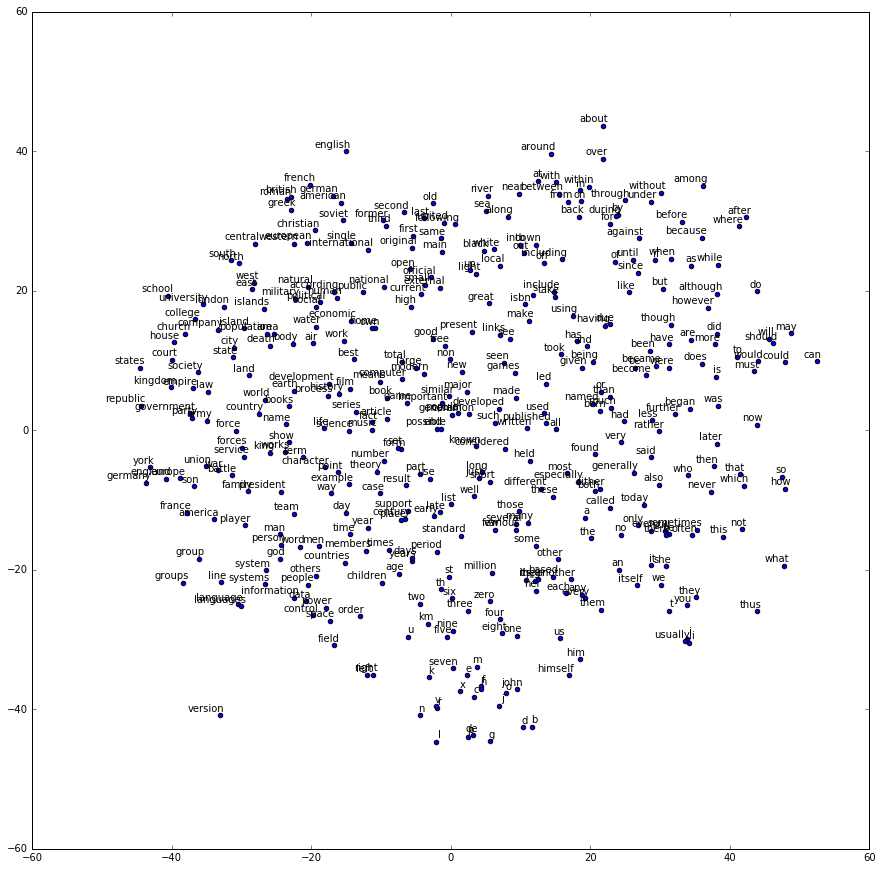

In [12]:
print(final_embeddings.shape)

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

print(np.sum(final_embeddings[0]))
print(np.sum(np.square(final_embeddings[0])))

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels)
    pylab.figure(figsize = (15,15))
    for i, label in enumerate(labels):
        x, y = embeddings [i,:]
        pylab.scatter(x,y)
        pylab.annotate(label, xy = (x,y), xytext = (5,2), textcoords = 'offset points',
                       ha = 'right', va ='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)

## CBOW

### Training

In [13]:
print('Most common words (+UNK)\n', count[:5])
print('\nSample data\n', data[:10])
print('\nSample count\n', count[:10])
print('\nSample dict\n', dictionary.items()[:10])
print('\nSample Reverse Dictionary\n', reverse_dictionary.items()[:10])

Most common words (+UNK)
 [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]

Sample data
 [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]

Sample count
 [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]

Sample dict
 [('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554), ('sowell', 40562), ('sonja', 38175), ('showa', 32906), ('woods', 6263), ('hsv', 44222)]

Sample Reverse Dictionary
 [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


In [14]:
data_index = 0

def generate_batch_cbow(batch_size, bag_window):
    """
    input
    
    batch_size:    batch size
    bag_window:    context window 한쪽 크기 # [ bag window         target        bag window ]
    
    
    return
    
    batch:         mini-batch of data
    labels:        labels of mini-batch
    
    """
    global data_index
    # assert batch_size % num_skips == 0 # batch_size는 num_skips의 배수
    # assert num_skips <= 2 * bag_window
    
    
    span = 2 * bag_window + 1 # [ bag window         target        bag window ]
    batch = np.ndarray(shape =(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape =(batch_size, 1), dtype = np.int32)
    
    buffer = collections.deque(maxlen = span)
    # deque: double ended queue, collecions 모듈의 확장된 list 클래스
    # 양쪽에 모두 pop, push 할 수 있음
    # append를 하는데 maxlen 을 넘어가면 왼쪽으로 한칸씩 밀림
    
    
    # 매 batch마다 buffer에 data 입력
    # buffer = data[data_index : data_index + span]
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    #print(buffer)
    
    for i in range(batch_size):
        buffer_list = list(buffer)
        #print(buffer_list)
        
        # [ bag window         target        bag window ]
        #                      target 을 pop으로 labels로 보냄
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        #print(batch[i])
        
        # context window 를 한 칸 오른쪽으로 이동
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        #print(buffer)
    
    #print(buffer)
    return batch, labels

In [15]:
print("Generating batch ... \n")
batch, labels = generate_batch_cbow(batch_size=8, bag_window=2)

print('\nbatch shape', batch.shape)
print('\nlabels shape', labels.shape)

print("\nSample batches:\n", batch[:5])
print("\nSample labels:\n", labels[:5],'\n')
for i in range(5):
    print(batch[i,:], '->', labels[i,0])
    print([reverse_dictionary[batch[i,j]] for j in range(batch.shape[1])], '->', reverse_dictionary[labels[i,0]])

print('\nbatch\n',batch)
print('\nlabels\n', labels)

Generating batch ... 


batch shape (8, 4)

labels shape (8, 1)

Sample batches:
 [[5239 3084    6  195]
 [3084   12  195    2]
 [  12    6    2 3137]
 [   6  195 3137   46]
 [ 195    2   46   59]]

Sample labels:
 [[  12]
 [   6]
 [ 195]
 [   2]
 [3137]] 

[5239 3084    6  195] -> 12
['anarchism', 'originated', 'a', 'term'] -> as
[3084   12  195    2] -> 6
['originated', 'as', 'term', 'of'] -> a
[  12    6    2 3137] -> 195
['as', 'a', 'of', 'abuse'] -> term
[   6  195 3137   46] -> 2
['a', 'term', 'abuse', 'first'] -> of
[195   2  46  59] -> 3137
['term', 'of', 'first', 'used'] -> abuse

batch
 [[5239 3084    6  195]
 [3084   12  195    2]
 [  12    6    2 3137]
 [   6  195 3137   46]
 [ 195    2   46   59]
 [   2 3137   59  156]
 [3137   46  156  128]
 [  46   59  128  742]]

labels
 [[  12]
 [   6]
 [ 195]
 [   2]
 [3137]
 [  46]
 [  59]
 [ 156]]


In [16]:
batch_size = 8
print('data:', [reverse_dictionary[di] for di in data [:batch_size]])

for bag_window in [1,2,3,4]:
    data_index = 0
    
    batch, labels = generate_batch_cbow(batch_size = batch_size, bag_window = bag_window)
    print("\nwith bag_window = %d" % (bag_window))
    print("\n    batch:", [[reverse_dictionary[w] for w in bi] for bi in batch])
    print("\n    labels:", [reverse_dictionary[li] for li in labels.reshape(batch_size)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with bag_window = 1

    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]

    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with bag_window = 2

    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]

    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with bag_window = 3

    batch: [['anarchism', 'originated', 'as', 'term', 'of', 'abuse'], ['originated', 'as', 'a', 'of', 'abuse', 'first'], ['as', 'a', 'term', 'abuse', 'first', 'used'], ['a', 'term', 'of', 'first', 'used', 'against'], ['term', 'of', 'abuse', 'u

In [17]:
batch_size = 128
embedding_size = 128
#skip_window = 1
#num_skips = 2
bag_window = 2

valid_size  = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
# [0 ~ valid_wind]의 리스트에서 valid_size개 만큼 샘플링
# 여기서는 0~99 중 랜덤하게 16개 샘플링
num_sampled = 64

graph = tf.Graph()

with graph.as_default():#, tf.device('/cpu:0'):
    
    # input data
    train_dataset = tf.placeholder(tf.int32, shape = [batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    
    # Variables
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
    ) # 전체 vocabulary를 embedding_size 크기의 벡터로 embedding, -1.0 ~ 1.0 의 값으로 초기화
    
    
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                           stddev = 1.0 / math.sqrt(embedding_size))
    )
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # 위에서 정의한 embeddings 중 train_dataset에 해당되는 단어들만 추출 => input
    
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, tf.reduce_sum(embed,1),
                                   train_labels, num_sampled, vocabulary_size
        )
    )
    
    # Optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Similarity
    # similarity between minibatch ~ all embeddings
    # cosine distance
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset
    )
    similarity = tf.matmul(
        valid_embeddings, tf.transpose(normalized_embeddings)
    ) # valid_dataset에 대응하는 cosine distance = valid_embeddings 와 normalized_embeddings 의 곱
    

In [18]:
num_steps = 100001
loss_cbow = []

tic = time.clock()

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print('initialized')
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch_cbow(
            batch_size, bag_window   # num_skips, skip_window
        )
        
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, batch_loss = session.run([optimizer, loss], feed_dict = feed_dict)
        
        average_loss += batch_loss
        
        # 매 2000 스텝마다 average loss 출력
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print('Average loss at step %d: %f' % (step, average_loss))
            loss_cbow.append(average_loss)
            average_loss = 0
        
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()     
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                #print(valid_word)
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s, ' % (log, close_word)
                print(log)
                
    final_embeddings = normalized_embeddings.eval()
    
toc = time.clock()

print(toc-tic)

initialized
Average loss at step 0: 7.745485
Nearest to he: marathi,  earning,  mexican,  tamazight,  bresson,  indecision,  voice,  zoning, 
Nearest to has: clinician,  myron,  meteorite,  indigenous,  salient,  uncompetitive,  sitcoms,  booksellers, 
Nearest to used: greenberg,  counted,  commutes,  outmoded,  kurdistan,  theater,  lorry,  modernize, 
Nearest to a: grinding,  qd,  fyodor,  dostoyevsky,  paradigm,  milken,  phagspa,  collides, 
Nearest to other: poll,  meteorologists,  las,  palmas,  crest,  mismanagement,  amazigh,  refreshing, 
Nearest to may: macgregor,  wittgenstein,  callisthenes,  teach,  defensive,  cetacea,  krs,  ornamented, 
Nearest to from: cuyahoga,  harder,  caret,  norway,  scientifically,  hells,  apocalypse,  universelle, 
Nearest to by: centimeter,  palladium,  observant,  bothered,  moltke,  crunch,  kiwi,  flap, 
Nearest to after: pouch,  sages,  dao,  leisure,  occidental,  editor,  slowdown,  protectors, 
Nearest to history: divisions,  bebox,  pr

(50000, 128)
-0.0281451
1.0


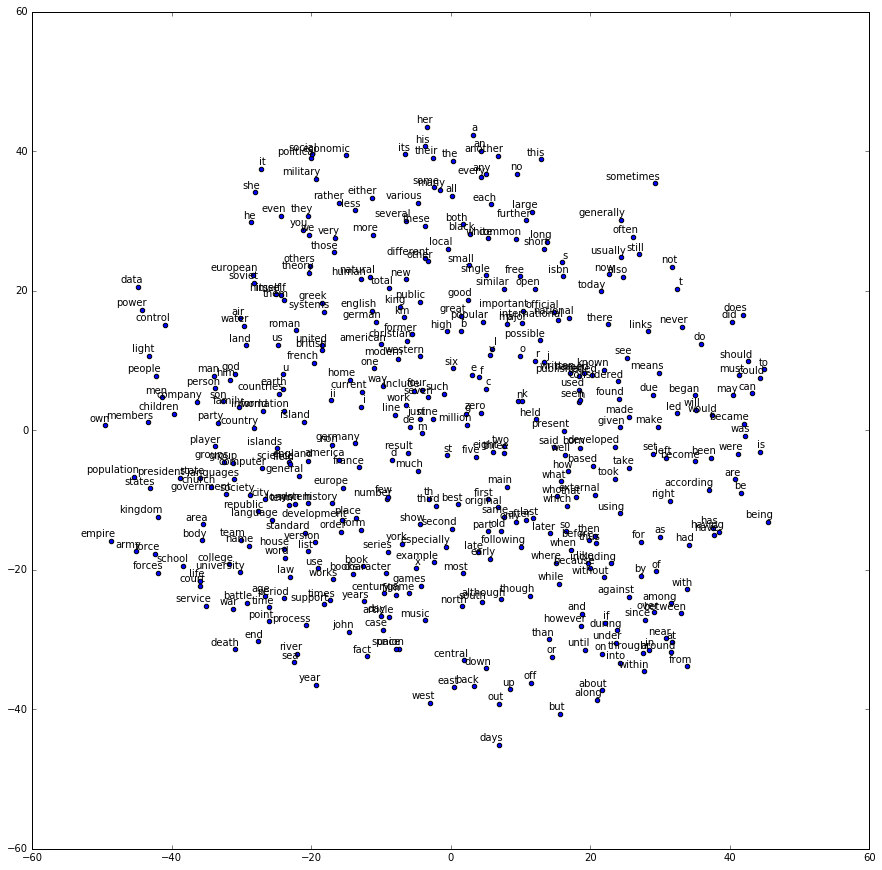

In [19]:
print(final_embeddings.shape)

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

print(np.sum(final_embeddings[0]))
print(np.sum(np.square(final_embeddings[0])))

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels)
    pylab.figure(figsize = (15,15))
    for i, label in enumerate(labels):
        x, y = embeddings [i,:]
        pylab.scatter(x,y)
        pylab.annotate(label, xy = (x,y), xytext = (5,2), textcoords = 'offset points',
                       ha = 'right', va ='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)

## Skip-gram VS CBOW

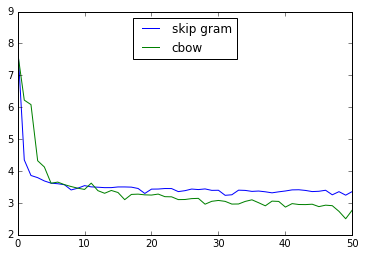

In [20]:
steps = np.arange(len(loss_cbow))
fig, ax = plt.subplots()

ax.plot(steps, loss_skip_gram, 'b', label="skip gram")
ax.plot(steps, loss_cbow, 'g', label="cbow")

# legend
legend = ax.legend(loc='upper center')

plt.show()